# 📘 OTTO – Multi-Objective Recommender System

## Notebook 1: Day 1–2 (EDA + Baseline Candidate Generation)

# Day 1 — Dataset Loading & Basic EDA

## 🧭 Introduction
In Day 1, we focus on preparing the environment, loading the OTTO dataset,  
and performing lightweight EDA that does not exceed the memory limits in Kaggle.

The dataset uses `.jsonl` format, which can be extremely large.  
To avoid kernel crashes, we read the data using **streaming** instead of loading the whole file.

## 1. Setup and Imports

In [2]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

train_path = "/kaggle/input/recsys-dataset/otto-recsys-train.jsonl"
test_path = "/kaggle/input/recsys-dataset/otto-recsys-test.jsonl"
print("Train file exists:", os.path.exists(train_path))
print("Test file exists:", os.path.exists(test_path))



Train file exists: True
Test file exists: True


## 2. Streaming Reader(Memory-Safe)

In [3]:
def stream_jsonl(path, chunk_size=200_000):
    batch = []
    with open(path, "r") as f:
        for line in f:
            batch.append(json.loads(line))
            if len(batch) >= chunk_size:
                yield batch
                batch = []
    if batch:
        yield batch

## 3.Lightweight EDA

In [4]:
event_count = Counter()
item_count = Counter()
num_sessions = 0

for batch in tqdm(stream_jsonl(train_path, chunk_size=200_000)):
    for session in batch:
        num_sessions += 1
        for action in session["events"]:
            event_count[action["type"]] += 1
            item_count[action["aid"]] += 1

print("Total sessions:", num_sessions)
print("Event distribution:", event_count)
print("Top items:", item_count.most_common(10))

65it [09:25,  8.70s/it]


Total sessions: 12899779
Event distribution: Counter({'clicks': 194720954, 'carts': 16896191, 'orders': 5098951})
Top items: [(1460571, 129004), (485256, 126836), (108125, 118524), (29735, 113279), (1733943, 105091), (832192, 91325), (184976, 90244), (166037, 84657), (554660, 80197), (231487, 79872)]


## 4.Visualize Event Distribution


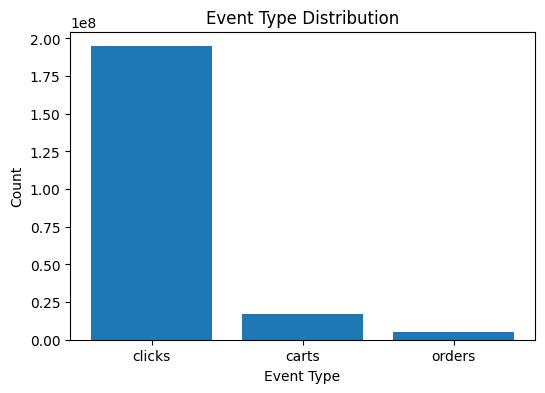

In [10]:
plt.figure(figsize=(6,4))
plt.bar(event_count.keys(), event_count.values())
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

## 5.Sample Item Popularity Plot

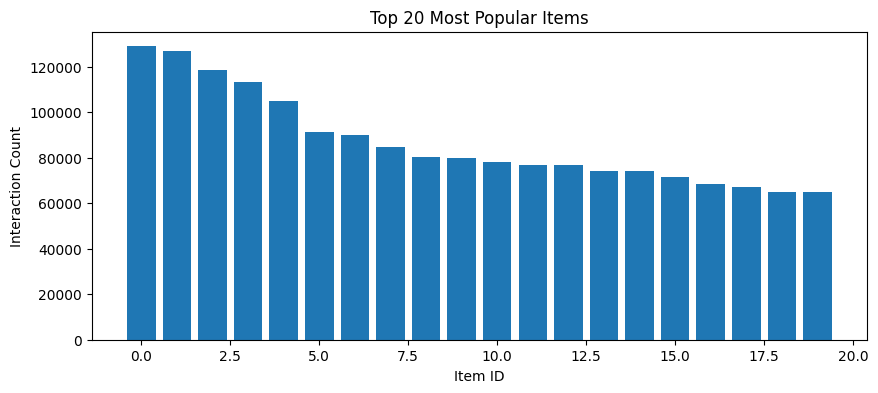

In [11]:
top_items = item_count.most_common(20)
items, counts = zip(*top_items)

plt.figure(figsize=(10,4))
plt.bar(range(len(items)), counts)
plt.title("Top 20 Most Popular Items")
plt.xlabel("Item ID")
plt.ylabel("Interaction Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os


os.makedirs("visualisation", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.bar(["a","b","c"], [10,20,30])
plt.title("Demo")


plt.savefig("visualisation/demo_plot.png", dpi=300, bbox_inches='tight')

plt.show()

# 📓 Day 2 – Exploratory Data Analysis

# Day 2 — Exploratory Data Analysis (EDA)
In today's notebook, we explore the structure of the OTTO event dataset.
We aim to understand user behavior, event distribution, and item popularity.
Insights in this step will guide feature engineering in later stages.

## 🧭Main Steps
1. Load data efficiently  
2. Inspect dataset shape and schema  
3. Event type distribution  
4. Session length analysis  
5. Item popularity statistics  
6. Visualize key findings  

---

## 1.load data


In [5]:
import pandas as pd

path = "/kaggle/input/otto-recsys-dataset/train.parquet"


df = pd.read_parquet(path).head(500000)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   aid      500000 non-null  int64 
 1   ts       500000 non-null  uint64
 2   type     500000 non-null  uint8 
 3   session  500000 non-null  int64 
dtypes: int64(2), uint64(1), uint8(1)
memory usage: 11.9 MB


,aid,ts,type,session
0,1517085,1659304800025,0,0
1,1563459,1659304904511,0,0
2,1309446,1659367439426,0,0
3,16246,1659367719997,0,0
4,1781822,1659367871344,0,0


## 2.Inspect structure


In [6]:
print(df.shape)
df.info()
df.iloc[0]

(500000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   aid      500000 non-null  int64 
 1   ts       500000 non-null  uint64
 2   type     500000 non-null  uint8 
 3   session  500000 non-null  int64 
dtypes: int64(2), uint64(1), uint8(1)
memory usage: 11.9 MB


aid        1.517085e+06
ts         1.659305e+12
type       0.000000e+00
session    0.000000e+00
Name: 0, dtype: float64

## 3.Event type distribution

In [59]:
import matplotlib.pyplot as plt
print("Columns:", df.columns.tolist())



events = df.explode("ts")
events_normalized = pd.json_normalize(events["ts"])

# 合并回原始 session
events_full = pd.concat([events.drop(columns="ts"), events_normalized], axis=1)

events_full.head()



Columns: ['aid', 'ts', 'type', 'session']


,aid,type,session
0,1517085,0,0
1,1563459,0,0
2,1309446,0,0
3,16246,0,0
4,1781822,0,0


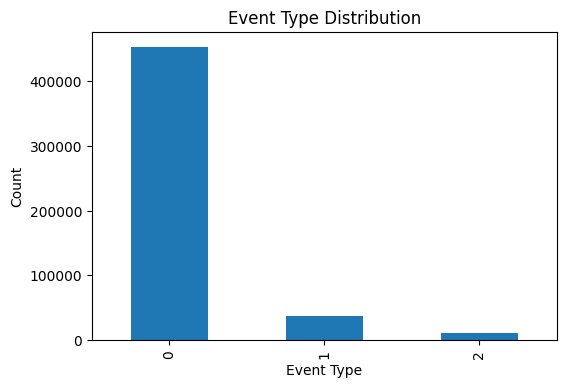

type
0    453851
1     36326
2      9823
Name: count, dtype: int64

In [60]:
# Statics
event_counts = events_full["type"].value_counts()

plt.figure(figsize=(6,4))
event_counts.plot(kind='bar')
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

event_counts

In [61]:
events_full.head()

,aid,type,session
0,1517085,0,0
1,1563459,0,0
2,1309446,0,0
3,16246,0,0
4,1781822,0,0


## 4.Session Length Analysis

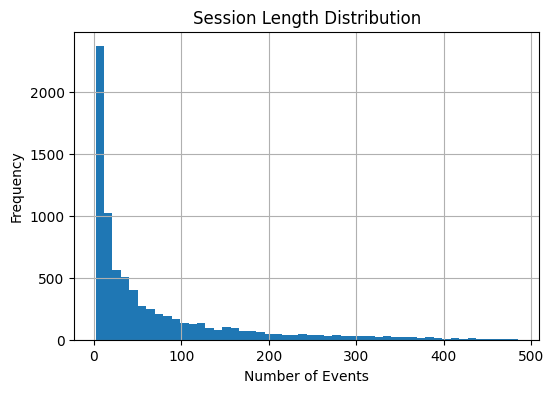

count    7633.000000
mean       65.505044
std        87.266259
min         2.000000
25%         8.000000
50%        28.000000
75%        86.000000
max       485.000000
Name: aid, dtype: float64

In [62]:
session_len = events_full.groupby("session")["aid"].count()

plt.figure(figsize=(6,4))
session_len.hist(bins=50)
plt.title("Session Length Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Frequency")
plt.show()

session_len.describe()

## 5.Item Popularity

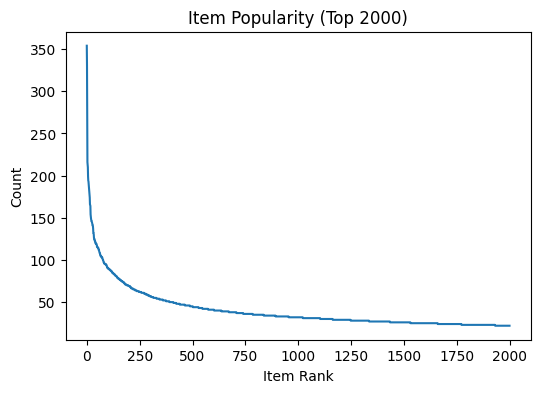

aid
29735      354
832192     331
108125     265
166037     216
1733943    213
Name: count, dtype: int64

In [63]:


item_popularity = events_full["aid"].value_counts()

plt.figure(figsize=(6,4))
plt.plot(item_popularity.values[:2000])
plt.title("Item Popularity (Top 2000)")
plt.xlabel("Item Rank")
plt.ylabel("Count")
plt.show()

item_popularity.head()

# 📝 Key Insights from Day 2

### 1. Event Type Distribution
- **Clicks** dominate the dataset
- **Carts** and **Orders** are less frequent but more valuable  
These insights tell us we need weighting strategies later.

---

### 2. Session Length
- Most sessions contain **5–30 events**
- A small number of extremely long sessions exist  
Later steps will handle trimming or normalization.

---

### 3. Item Popularity
- Popularity follows **power-law distribution**  
We might use:
- item embeddings
- frequency-based priors
- popularity decay

---

Tomorrow (Day 3) we will:
✔ Build session-level features  
✔ Construct co-visitation matrices